In [77]:
import os, sys
import torch
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from scipy.sparse.linalg import spsolve
import discretize
import magneticsForward as MF
import solvers
from torchModelDataLoader import modelDataset
from torch.utils.data import DataLoader

dim = torch.tensor([128,128,64])
h = torch.tensor([100.0, 100.0, 100.0])
dirs = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
forMod = MF.magnetics(dim, h, dirs, device='cpu')
#forMod = MF.testFM(dim, h, dirs, device='cpu')

mesh = discretize.TensorMesh([[(100, 128)], [(100, 128)], [(100, 64)]])

# batch_size = 50
# dataset = modelDataset(directory='./models', dims=3, scale=4.11)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# max_hold = []
# for i, data in enumerate(dataloader, 0):
    
#     print(data.shape, data.max())
#     max_hold.append(data)
#     # plt.imshow(data[0, :, :].cpu().detach().numpy().T)
#     # plt.show()

# # print(f"max_data: {np.max(max_hold)}")

# M = max_hold[0][25, :, :, :]
# plt.imshow(M[:, :, 0].cpu().detach().numpy())
# plt.show()
# # set the magnetization model
# M = torch.ones(dim[0], dim[1], dim[2], device='cpu') * 0.0
# M[40:60, 40:60, 10:40] = 0.1

# D = forMod(M)*1e8

# sol = solvers.CGLS(forMod, CGLSit=100, eps = 1e-5, device='cpu')

# x, r = sol(D, M*0)

# # Ax = b   A Ez = b 
print('Done')


Done


1048576 torch.Size([128, 128, 64])


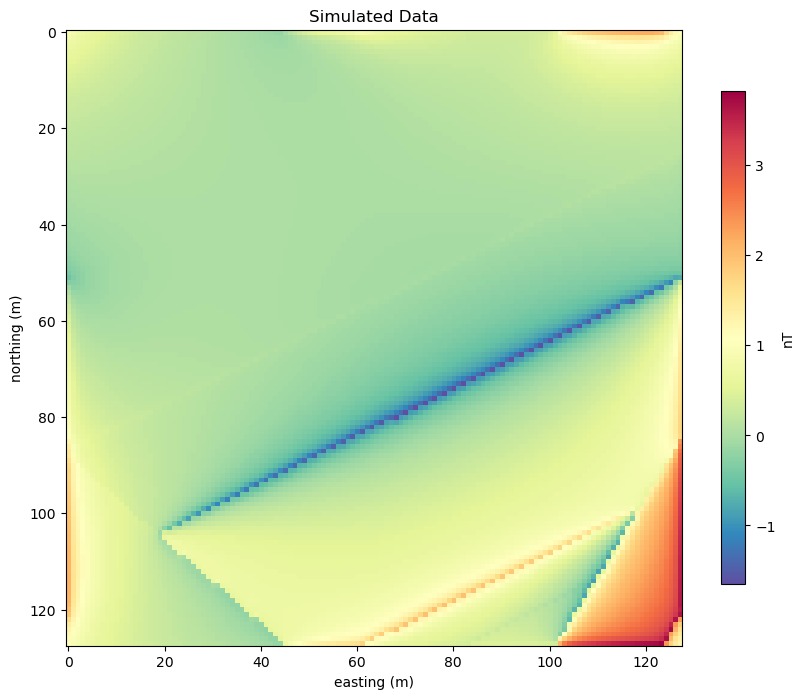

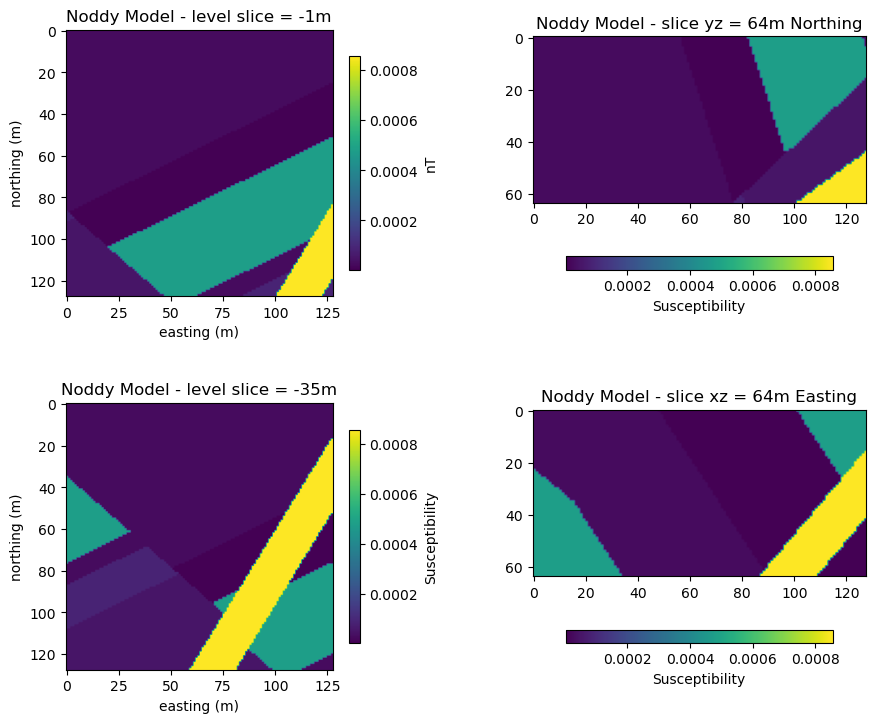

In [78]:
M = max_hold[1][49, :, :, :]
print(mesh.nC, M.shape)
discretize.TensorMesh.write_UBC(mesh,'tensor_dm.msh', models={'dm.con': M.cpu().detach().numpy().flatten(order='F')})
D = forMod(M * 4.11)*1e9

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
ims = axs.imshow(D.cpu().detach().numpy(), cmap="Spectral_r")
axs.set_xlabel("easting (m)")
axs.set_ylabel("northing (m)")
axs.set_title("Simulated Data")
plt.colorbar(ims, shrink=0.8, label="nT")

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
ims = axs[0, 0].imshow(M[:, :, 1].cpu().detach().numpy())
axs[0, 0].set_xlabel("easting (m)")
axs[0, 0].set_ylabel("northing (m)")
axs[0, 0].set_title(f"Noddy Model - level slice = -{1}m")
plt.colorbar(ims, shrink=0.8, label="nT")
# plt.show()

im1 = axs[1, 0].imshow(M[:, :, 50].cpu().detach().numpy())
plt.colorbar(im1, shrink=0.8, label="Susceptibility")
axs[1, 0].set_xlabel("easting (m)")
axs[1, 0].set_ylabel("northing (m)")
axs[1, 0].set_title(f"Noddy Model - level slice = -{35}m")

im2 = axs[0, 1].imshow(M[:, 64, :].cpu().detach().numpy().T)
# axs[0, 1].invert_yaxis()
# axs[0, 1].invert_xaxis()
axs[0, 1].set_title(f"Noddy Model - slice yz = {64}m Northing")
plt.colorbar(im2, shrink=0.8, orientation='horizontal', label='Susceptibility', pad=0.2)
im3 = axs[1, 1].imshow(M[64, : , :].cpu().detach().numpy().T)
plt.colorbar(im3, shrink=0.8, orientation='horizontal', label='Susceptibility', pad=0.2)
# axs[1, 1].invert_yaxis()
axs[1, 1].set_title(f"Noddy Model - slice xz = {64}m Easting")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

In [53]:
import numpy as np
from choclo.prism import magnetic_field
import math
import numba

def components_vector(amp, incl, decl):
    x = amp * math.sin(math.radians(incl)) * math.cos(math.radians(decl))
    y = amp * math.sin(math.radians(incl)) * math.sin(math.radians(decl))
    z = amp * math.cos(math.radians(incl))
    return (x, y, z)


dim = np.asarray([1024,1024,512]) / 2
h = [100.0, 100.0, 100.0]
Dx = h[0]
Dy = h[1]

x = Dx*np.arange(-dim[0]+1,dim[0]+1)
y = Dy*np.arange(-dim[1]+1,dim[1]+1)

X,Y = np.meshgrid(x,y)

x = X.flatten()
y = Y.flatten()

# Define the boundaries of the prism as a 1d-array
prism = np.array([-10000.0, 10000.0, -10000.0, 10000.0, -40000.0, -10000.0])

magnetization = components_vector(0.1, 0.0, 0.0)
# magnetization = (0.1, 0.1, 0.1)

@numba.jit(nopython=True)
def mag_jit(x, y, prism, magnetization):

    results = []

    for ii in range(x.shape[0]):

        # Define a single computation point
        easting, northing, upward = x[ii], y[ii], 10.0

        # Compute the upward component of the grav. acceleration
        mag = magnetic_field(easting, northing, upward, prism, magnetization)
        results.append(np.sum(np.asarray(mag)**2)**0.5)

    return results

results = mag_jit(x, y, prism, magnetization)


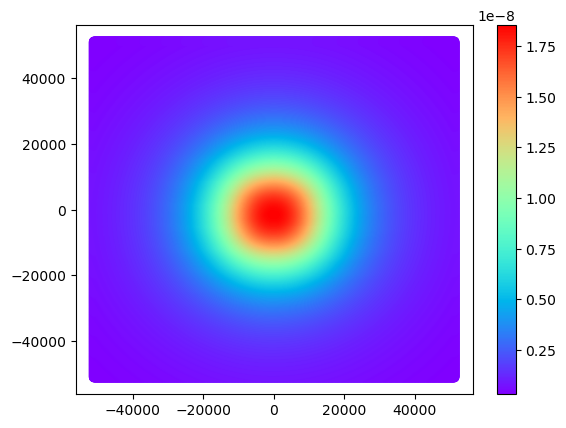

In [54]:
plt.scatter(x, y, c=results, cmap='rainbow')
plt.colorbar()